In [13]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

import kagglehub

# Download latest version
path = kagglehub.dataset_download("quynhlecl/lung-cancer-x-ray")
print("Path to dataset files:", path)



Path to dataset files: /root/.cache/kagglehub/datasets/quynhlecl/lung-cancer-x-ray/versions/1


In [14]:
# Set the root dataset path
root_dataset_path = "/root/.cache/kagglehub/datasets/quynhlecl/lung-cancer-x-ray/versions/1/chest_xray_lung/"

train_dataset_path = os.path.join(root_dataset_path, "train")
test_dataset_path = os.path.join(root_dataset_path, "test")
val_dataset_path = os.path.join(root_dataset_path, "val")



In [15]:
# Function to explore the dataset
def explore_dataset(dataset_path):
    class_counts = {}
    total_images = 0

    for root, dirs, files in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
            total_images += num_files

    print("Dataset Overview:")
    print(f"Total Classes: {len(class_counts)}")
    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")

    return class_counts

class_counts = explore_dataset(root_dataset_path)


Dataset Overview:
Total Classes: 6
Total Images: 11727
Class Distribution:
  test: 2
  val: 2
  train: 2
  chest_xray: 3
  NORMAL: 1341
  Cancer: 3875


In [16]:
# Calculate class weights for imbalanced data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(list(class_counts.keys())),
    y=np.concatenate([[k] * v for k, v in class_counts.items()])
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.22473118279569892, 1: 0.649391001739995, 2: 290.27777777777777, 3: 435.4166666666667, 4: 435.4166666666667, 5: 435.4166666666667}


<ipython-input-17-249312ab1653>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


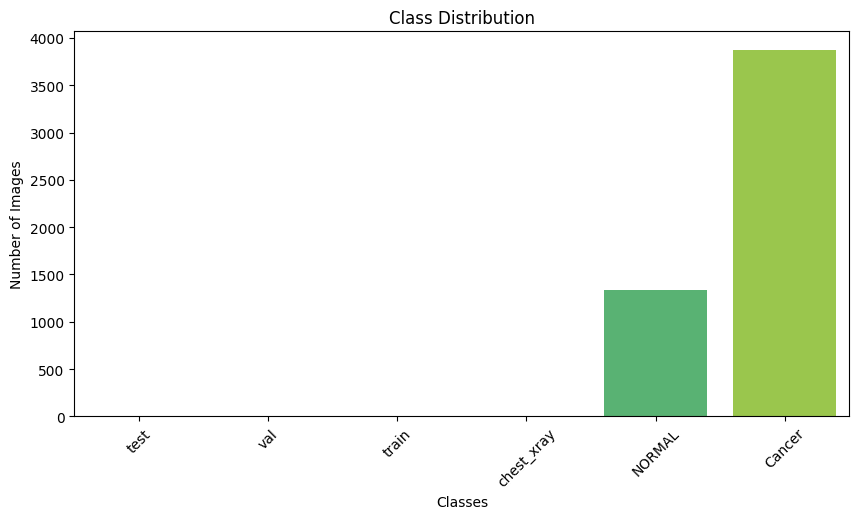

In [17]:
def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    sns.barplot(x=classes, y=counts, palette="viridis")
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(class_counts)

In [18]:

# Data Augmentation
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data Generators
train_generator = train_gen.flow_from_directory(
    train_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)
val_generator = val_test_gen.flow_from_directory(
    val_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)
test_generator = val_test_gen.flow_from_directory(
    test_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
from tensorflow.keras.optimizers import Adam

# Model Definition using ResNet50
def create_model(learning_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(learning_rate=0.001)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 23850242 (90.98 MB)
Trainable params: 262530 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [20]:
from sklearn.model_selection import KFold

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_resnet.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

initial_learning_rate = 0.001

def extract_data_and_labels(generator):
    data = []
    labels = []
    for _ in range(len(generator)):
        images, batch_labels = next(generator)  # Use the built-in next function
        data.append(images)
        labels.append(batch_labels)
    return np.vstack(data), np.concatenate(labels)

# Extract data and labels
train_data, train_labels = extract_data_and_labels(train_generator)

# Initialize KFold
kfold = KFold(n_splits=2, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation
fold_no = 1
results = []
for train_idx, val_idx in kfold.split(train_data, train_labels):
    print(f"Training Fold {fold_no}...")

    # Create data generators for the current fold
    train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(
        train_data[train_idx], train_labels[train_idx], batch_size=16
    )
    val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(
        train_data[val_idx], train_labels[val_idx], batch_size=16
    )

    # Create a new model instance
    model = create_model(learning_rate=initial_learning_rate)

    # Train the model
    history = model.fit(
        train_data_gen,
        epochs=3,
        validation_data=val_data_gen,
        callbacks=[early_stopping, model_checkpoint, reduce_lr]
    )

    # Evaluate the model
    val_loss, val_acc = model.evaluate(val_data_gen)
    print(f"Fold {fold_no} - Validation Accuracy: {val_acc:.2f}")
    results.append({'fold': fold_no, 'val_loss': val_loss, 'val_acc': val_acc})
    model.save(f'fold_{fold_no}_model_resnet.keras')


    fold_no += 1
print("\nK-Fold Cross-Validation Results:")
for result in results:
    print(f"Fold {result['fold']} - Loss: {result['val_loss']:.4f}, Accuracy: {result['val_acc']:.4f}")

Training Fold 1...
Epoch 1/3
163/163 [==============================] - 967s 6s/step - loss: 0.3027 - accuracy: 0.8846 - val_loss: 0.1532 - val_accuracy: 0.9436 - lr: 0.0010
Epoch 2/3
163/163 [==============================] - 957s 6s/step - loss: 0.1727 - accuracy: 0.9321 - val_loss: 0.2042 - val_accuracy: 0.9099 - lr: 0.0010
Epoch 3/3
163/163 [==============================] - 485s 3s/step - loss: 0.1395 - accuracy: 0.9452
Fold 1 - Validation Accuracy: 0.95
Training Fold 2...
Epoch 1/3
163/163 [==============================] - 954s 6s/step - loss: 0.2973 - accuracy: 0.8976 - val_loss: 0.1660 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 2/3
163/163 [==============================] - 942s 6s/step - loss: 0.1581 - accuracy: 0.9410 - val_loss: 0.2283 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 3/3
163/163 [==============================] - 471s 3s/step - loss: 0.1399 - accuracy: 0.9440
Fold 2 - Validation Accuracy: 0.94

K-Fold Cross-Validation Results:
Fold 1 - Loss: 0.1395, Accuracy: 0.945

20/20 [==============================] - 106s 5s/step - loss: 0.2907 - accuracy: 0.8798
Test Accuracy: 0.88
20/20 [==============================] - 109s 5s/step
              precision    recall  f1-score   support

      Cancer       0.94      0.86      0.90       390
      NORMAL       0.80      0.91      0.85       234

    accuracy                           0.88       624
   macro avg       0.87      0.89      0.88       624
weighted avg       0.89      0.88      0.88       624

AUC-ROC: 0.89


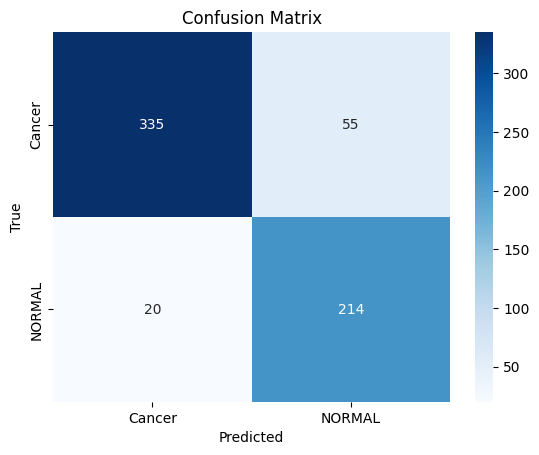

In [21]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Classification Report and Metrics
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# AUC-ROC Score
auc = roc_auc_score(y_true, y_pred)
print(f"AUC-ROC: {auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 6s 6s/step


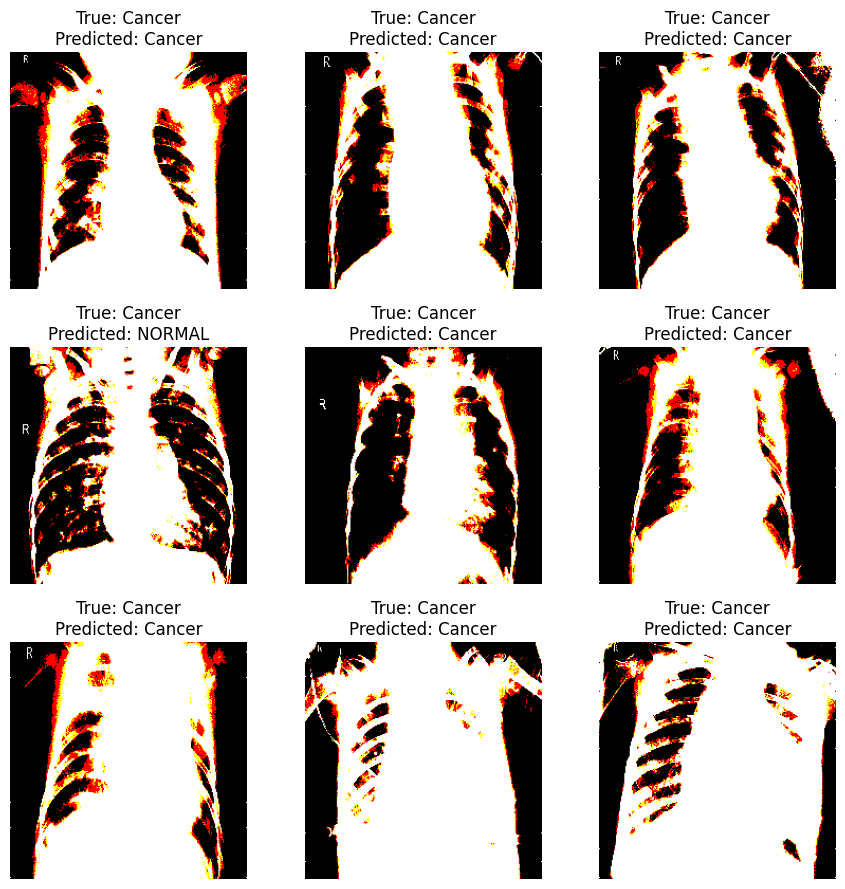

In [25]:
def visualize_predictions(generator, model, num_images=5):
    # Get a batch of images and labels from the generator
    images, true_labels = next(generator)

    # Make predictions
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert true_labels to integers
    true_labels = true_labels.astype(int)

    # Get class names
    class_names = list(generator.class_indices.keys())

    # Set up the plot
    plt.figure(figsize=(9, 9))

    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize predictions
visualize_predictions(test_generator, model, num_images=9)